In [1]:
%matplotlib inline
from __future__ import division, print_function

import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

plt.ion()  # インタラクティブ・モード

In [2]:
# データをダウンロード
# !wget -P ./data https://download.pytorch.org/tutorial/hymenoptera_data.zip
# # zipファイルを解凍
# !unzip ./data/hymenoptera_data.zip -d ./data

In [3]:
# 訓練データ用のデータ拡張と正規化
# 検証データ用には正規化のみ実施
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "data/hymenoptera_data"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

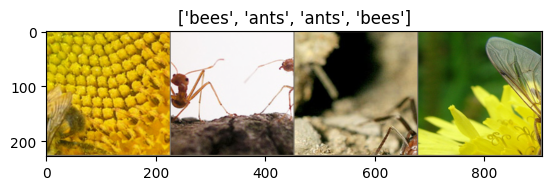

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # プロット図が更新されるように少しだけ一時停止


# 訓練データのバッチを取得する
inputs, classes = next(iter(dataloaders["train"]))

# バッチからグリッドを作成する
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # 各エポックには訓練フェーズと検証フェーズがあります
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # モデルを訓練モードに設定します
            else:
                model.eval()  # モードを評価するモデルを設定します

            running_loss = 0.0
            running_corrects = 0

            # データをイレテートします
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにします
                optimizer.zero_grad()

                # 順伝播
                # 訓練の時だけ、履歴を保持します
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練の時だけ逆伝播＋オプティマイズを行います
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # 損失を計算します
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # モデルをディープ・コピーします
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # ベストモデルの重みをロードします
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(weights=True)
num_ftrs = model_ft.fc.in_features
# ここでは，各出力サンプルのサイズは2に設定されています
# なお、NN.Linear(num_ftrs, len(class_names))という書き方で一般化することもできます。
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# ネットワークのすべてのパラメータが最適化対象です
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7エポックごとに学習率を1/10ずつ減衰させます
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.5992 Acc: 0.7172
val Loss: 0.4895 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.3424 Acc: 0.8811
val Loss: 0.4271 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.5374 Acc: 0.7828
val Loss: 0.4378 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.6511 Acc: 0.7254
val Loss: 0.1868 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4023 Acc: 0.8197
val Loss: 0.3268 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4313 Acc: 0.8279
val Loss: 0.3545 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5335 Acc: 0.7910
val Loss: 0.2301 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3041 Acc: 0.8689
val Loss: 0.2690 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2857 Acc: 0.8893
val Loss: 0.2488 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3499 Acc: 0.8566
val Loss: 0.2664 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3194 Acc: 0.8730
val Loss: 0.2255 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3289 Acc: 0.8648
val Loss: 0.2414 Acc: 0.9085

Ep

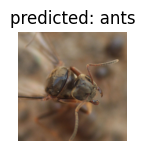

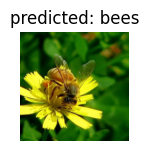

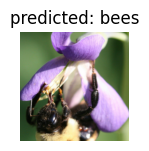

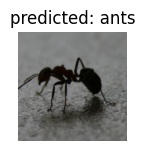

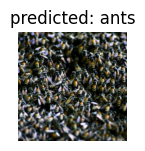

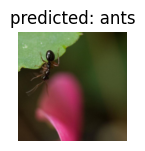

In [13]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(weights=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.5732 Acc: 0.6598
val Loss: 0.2398 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4501 Acc: 0.8033
val Loss: 0.6404 Acc: 0.7255

Epoch 2/24
----------
train Loss: 0.6333 Acc: 0.7418
val Loss: 0.2016 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3783 Acc: 0.8115
val Loss: 0.2436 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4126 Acc: 0.8033
val Loss: 0.1997 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4403 Acc: 0.8197
val Loss: 0.2706 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4871 Acc: 0.7992
val Loss: 0.1984 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3707 Acc: 0.8156
val Loss: 0.2055 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3451 Acc: 0.8525
val Loss: 0.1988 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.4705 Acc: 0.8156
val Loss: 0.2039 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3979 Acc: 0.8402
val Loss: 0.1857 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3472 Acc: 0.8361
val Loss: 0.1922 Acc: 0.9542

Ep

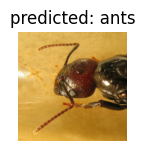

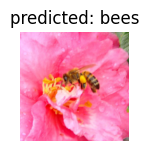

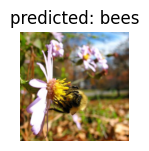

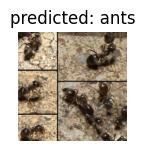

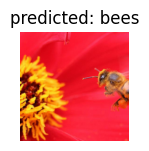

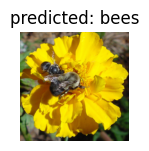

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()